# Predicting Deliveroo Food Preparation Times 
## Andre Chan

Deliveroo is committed to providing an optimal delivery experience for its customers, restaurants and riders. <br><br>
The goal of this project is to build a model that is able to predict the food preparation time for each order, based on data relating to the order and the restaurant preparing it. We further discuss how the model may be applied at Deliveroo. <br><br>
The project is organised as follows:

[**Preliminaries**](#preliminaries)<br> 
[**Data Preprocessing**](#preprocessing)<br> 
[**Data Exploration and Visualisation**](#exploration)<br> 
[**Feature Engineering**](#featureengineering)<br> 
[**Modelling**](#modelling)<br> 
[**Evaluation**](#evaluation)<br> 
[**Use-Cases**](#usecases)<br> 
[**Further Work**](#furtherwork)


<a id='preprocessing'></a>
# Preliminaries

<!-- This project was written in Python 3.8.3  -- though it should run with Python 3.5 and above. If not, consider these [instructions](https://stackoverflow.com/questions/49428381/how-to-change-jupyter-kernel-from-python-2-to-python-3/54229256#54229256). -->

First, we `pip install` the Python packages used in this project from the `requirements.txt` file. <br>

In [1]:
import sys

In [2]:
%%capture
!{sys.executable} -m pip install -r requirements.txt  # Install packages into the current Python kernel

A much better approach would **containerise** this project using Docker.

A Dockerfile could contain the 'instructions' to run the project on any machine - including installing the required packages and a compatible Python version, together with the source code.

<a id='preprocessing'></a>
# Data Preprocessing

We **import** the data and **join** the `orders` and `restaurants` tables on `restaurant_id`.<br> This is feasible for the relatively small size of our data and is helpful for feature engineering and modelling later.

In [3]:
from food_prep_prediction.data import *
from food_prep_prediction.exploration import *

# Read data & join orders and restaurants tables on restaurant_id
orders, restaurants = read_data(project_filepath=os.getcwd())
combined = orders.merge(restaurants, how='left', on='restaurant_id')

The `order_acknowledged_at` and `order_ready_at` columns are converted to **timestamp** format and we work in **local time** throughout. <br>

In [4]:
# Convert 'order_acknowledged_at' and 'order_ready_at' to timestamp format
combined = convert_str_to_timestamp(data=combined, columns=['order_acknowledged_at', 'order_ready_at'])

In this analysis, we consider **3 hours** to be a maximal reasonable time for food to be prepared.

**We remove orders from the data** that took longer than this, which may have been pre-orders or occasions when food was ready but not recorded, because they are not regarded as intended quantities for our model to predict. 

In [5]:
long_food_prep_time_stats(data=combined)
# Remove orders that took longer than 3 hours to prepare
combined = combined[combined['prep_time_seconds'] <= 3*3600]

202 orders (1.0%) took more than 3 hours of food prep time. The longest took 4258.3 hours.


The data is split such that the **test set contains all orders in the final week (after 24/06)**, with the remainder in the training set. 

This is chosen because some features we create will depend on other training examples, so a randomised train/test split may lead to **feature leakage**. Here, we have assumed that the conditional distribution $P(y|x)$ does not depend on time.

In [6]:
# Train-test split on 24/06/2015
train_data, test_data = train_test_split_by_date(data=combined, split_date=pd.datetime(2015, 6, 24))

<a id='featureengineering'></a>
# Feature Engineering

In the following, we transform the data to extract **additional** features that we hypothesise are predictive of the food preparation time:

|             Feature             	|  Type  	|                                        Description                                        	|
|:-------------------------------:	|:------:	|:-----------------------------------------------------------------------------------------:	|
|          ``meal_occasion``          	|    *string*     	| Time of order acknowledgement binned into<br> [breakfast, lunch, early_night, late_night] 	|
|            ``is_weekend``          	|   *bool*  	|                           Indicator that order was placed on Fri-Sun                          	|
|       ``city_mean_prep_time``       	|  *float* 	|                           Mean food prep time of the order city                           	|
|   ``type_of_food_mean_prep_time``   	|  *float* 	|                          Mean food prep time of the order cuisine                         	|
|    ``restaurant_price_per_item``    	|  *float* 	|                              Restaurant's average dish price                              	|
|  ``restaurant_average_order_value`` 	|  *float* 	|                            Restaurant's average order price (£)                           	|
| ``restaurant_average_daily_orders`` 	|  *float* 	|       Restaurant's average number of orders/day<br> (on days with at least 1 order)       	|

- We hypothesise that the **meal occasion** and whether it is a **weekend** affects restaurant traffic, and therefore the food preparation time.<br><br>
<a id='loo-te'></a>
- The data `city` and `type_of_food` are categorical variables with many sparse levels, so one-hot-encoding them may lead to *overfitting*.<br>Instead, we transform them into the features `city_mean_prep_time` and `type_of_food_mean_prep_time` that encode the mean food preparation times of the city/type of food in the training data. The observation itself is excluded in calculating this mean, to avoid *target leakage*. (This technique is called *Leave-One-Out Target Encoding*)<br><br>

<a id='latentinformation'></a>
- We also engineer restaurant-level features:<br>
`restaurant_price_per_item`: which may latently discriminate 'fast-food' to 'high-end' food<br>
`restaurant_average_order_value`: which may capture the size of orders a restaurant is used to<br>
`restaurant_average_daily_orders`: which may capture the restaurant's typical traffic

In [7]:
from food_prep_prediction.feature import *

# Engineer orders/timestamp features and append to training set
train_data['meal_occasion'] = bin_timestamps_to_meal_occasions(train_data['order_acknowledged_at_local']);
train_data['is_weekend'] = bin_timestamps_to_weekend_flag(train_data['order_acknowledged_at_local']);
train_data['city_mean_prep_time'] = target_encode(train_data['city'], train_data['prep_time_seconds'], leave_one_out=True).iloc[:, 1];
train_data['type_of_food_mean_prep_time'] = target_encode(train_data['type_of_food'], train_data['prep_time_seconds'], leave_one_out=True).iloc[:, 1];

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [8]:
# Engineer restaurant features and append to training set
train_data_by_restaurant = train_data.groupby(by='restaurant_id')

restaurant_price_per_item = extract_restaurant_feature(train_data_by_restaurant, 'restaurant_price_per_item')
restaurant_average_order_value = extract_restaurant_feature(train_data_by_restaurant, 'restaurant_average_order_value')
restaurant_average_daily_orders = extract_restaurant_feature(train_data_by_restaurant, 'restaurant_average_daily_orders')

train_data = merge_restaurant_features_to_data(
    train_data, [restaurant_price_per_item, restaurant_average_order_value, restaurant_average_daily_orders])

#### Temporal Data Leakage

In production, training set features that depend on other training examples should **only use those that occurred before it** - otherwise it leaks data from the future. Doing this causes the prediction set features (for which data in the future is not available) to possibly have a different data distribution, which harms the prediction performance due to *covariate shift*.<br>

In this analysis, we have violated this due to time constraints and instead implicitly assumed that these engineered features are time-independent. In addition, the given dataset is time-truncated, so the first observations in the dataset would have suffered because there are no observations prior to it.

<a id='exploration'></a>
# Data Exploration and Visualisation

In this section, we explore the data, including the features we engineered.

Because we want our model to generalise to unseen data, **we only explore the training set** to avoid leaking insights from the unseen test data.

<a id='correlations'></a>
#### Feature Correlations

We note the following high pairwise feature correlations. Since these features are hypothesised to capture different [latent information](#latentinformation) about the order/restaurant, and our chosen model is **robust to correlated features**, we decide not to drop any features at this stage.

In [9]:
get_high_pairwise_correlated_features(train_data, threshold=0.25)

Highest Pairwise Feature Correlations

restaurant_average_order_value  restaurant_price_per_item         0.56
restaurant_price_per_item       restaurant_average_order_value    0.56
order_value_gbp                 restaurant_average_order_value    0.39
restaurant_price_per_item       number_of_items                   0.37
restaurant_average_order_value  type_of_food_mean_prep_time       0.28


### Feature Exploration

We now visualise the features in the data with respect to the target variable, to motivate including them in the model (or not). For brevity, we focus on the most interesting findings.

#### Note about confounding

We note that a convincing plot that indicates variance in the target variable with respect to a feature **does not** suggest that the feature is ***causal*** for the target variable - or even an effective feature in a predictive model.<br><br>This is because there may be a ***confounding variable*** that influences both the feature and target variable. A more rigorous analysis could consider **partial dependence plots** that marginalise over the values of all other (or at least the correlated) features. 

#### Number of Items Ordered

The plot shows that the food prep time **increases** as the number of items ordered increases, supporting the `number_of_items` feature in the model. 

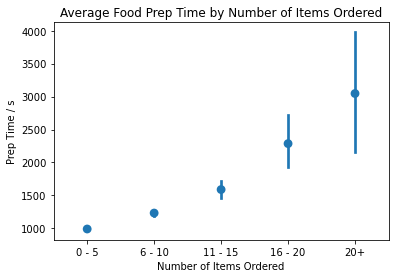

In [10]:
plot_prep_time_vs_no_items_ordered(train_data)

#### Meal Occasion

The plot shows that the food prep time **decreases** as the meal occasion becomes later in the day, supporting the `meal_occasion` feature in the model.

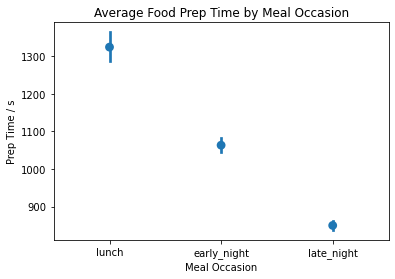

In [11]:
plot_prep_time_vs_meal_occasion(train_data)

#### City

The plot shows that *amongst English cities*, the mean food prep time varies ***between*** cities. However, partly due to sparsity in the number of orders per city, there is high variance in the food prep time ***within*** each city, shown by the large error bars. <br>

The exceptions are *Paris* and to a lesser extent *Berlin*, in which the mean food prep time is significantly less. However, these differences are confounded by the `country` variable.<br>

Due to the large number of sparse levels in the `city` variable, together with the fact that **after marginalising on `country`** there is not a significant difference in the food prep time between cities, it is decided to **ignore the city, and instead consider the country** in the model.

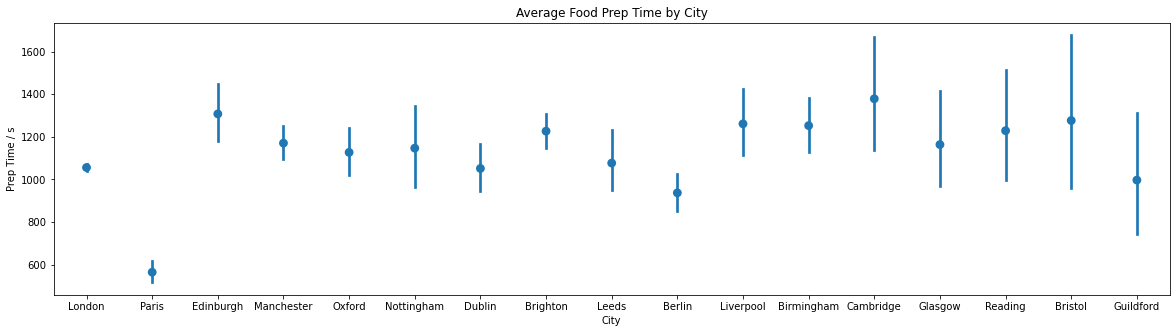

In [12]:
plot_prep_time_vs_city(train_data)

#### Type of Food

In contrast, the mean food prep time appears to vary more **between** different types of food, with lesser variance **within** many specific types of food - indicated by smaller error bars.

This supports using the *Leave-One-Out Target-Encoding* of the type of food, [motivated earlier](#loo-te), in the model.

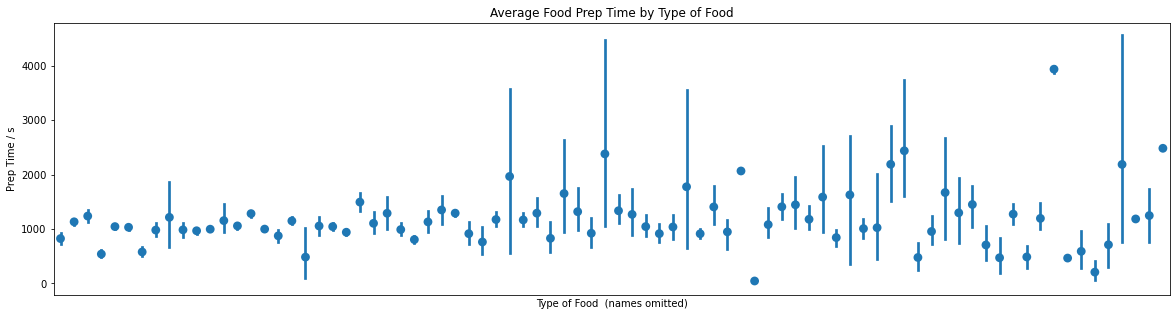

In [13]:
plot_prep_time_vs_type_of_food(train_data)

We performed the same analysis on all of the other features (omitted for brevity), leading to a decision to use the following features in the model:

|              Feature             	|   Type  	|
|:--------------------------------:	|:-------:	|
|         `order_value_gbp`        	| *float* 	|
|         `number_of_items`        	|  *int*  	|
|             `country`            	|  *str*  	|
|   `type_of_food_mean_prep_time`  	| *float* 	|
|          `meal_occasion`         	|  *str*  	|
|           `is_weekend`           	|  *bool* 	|
| `restaurant_average_order_value` 	| *float* 	|
|    `restaurant_price_per_item`   	| *float* 	|

A more thorough analysis might select an optimal set of features automatically, using *recursive feature elimination* or *forward selection*.

<a id='modelling'></a>
# Modelling

### Motivation

We develop a Random Forest model that predicts the food preparation time, conditional on features relating to the order and the restaurant. It is chosen for several reasons:
- As an aggregation of decision trees trained on different sets of features and (bootstrap) samples of the data, the model is less prone to overfitting, improving performance.

- Decision trees learn by iteratively splitting on the best (feature, value) combination in the data that minimises MSE. This learns nonlinear feature interactions and suits our continuous features (and outlier values they may take).

- Training is fast (since parallelisable) and would scale well with more data that would be accessible in reality. Real-time prediction is not instant, but fast enough for our [**deployment use-cases**](#production).

For an MVP, an alternative is Linear Regression, since it is more interpretable and real-time predictions (as a dot product) can be deployed without requiring an ML framework.


### Training

Since our dataset is small, the default hyperparameters may lead to individual trees overfitting, so we optimise:

|    Hyperparameter   	|                    Description                   	|              Grid              	|
|:-------------------:	|:------------------------------------------------:	|:------------------------------:	|
|    `n_estimators`   	|                  Number of trees                 	|     `[100, 150, ... 300]`    	|
|     `max_depth`     	|         Maximum number of levels in tree         	|     `[10, 20, 30, 40, None]`     	|
| `min_samples_split` 	|     Minimal samples required to split a node     	|           `[2, 5, 10]`           	|
|    `max_features`   	| Number of features considered for the best split 	| `[sqrt(n_features), n_features]` 	|

We use *Randomised Search Cross-Validation*, in which *100* sets of hyperparameters are uniformly sampled from the grid and the set with minimal *5-fold* CV error is used for the final model. 

In [14]:
from food_prep_prediction.model import RandomForestModel

# One-hot encode categorical features 'country' & 'meal_occasion' and append to training data
categorical_variables = {'country': ['UK', 'France', 'Ireland', 'Germany'], 'meal_occasion': ['breakfast', 'lunch', 'early_night', 'late_night']}
categories_column_names = ['country_UK', 'country_France', 'country_Ireland', 'country_Germany', 'meal_occasion_breakfast', 'meal_occasion_lunch', 'meal_occasion_early_night', 'meal_occasion_late_night']
feature_names = ['order_value_gbp', 'number_of_items', 'type_of_food_mean_prep_time', 'is_weekend', 'restaurant_average_order_value', 'restaurant_price_per_item'] + categories_column_names
label_name = 'prep_time_seconds'

random_forest_model = RandomForestModel()
train_data = random_forest_model.one_hot_encode(train_data, categorical_variables)

In this notebook, hyperparameter tuning has been disabled by default to save computation time: `tune_hyperparameters = False`.<br>
Under this setting, the optimal hyperparameters from a pretrained run are used.

In [15]:
tune_hyperparameters = False

# If not tuning hyperparameters, use optimal ones from previous run.
if not tune_hyperparameters:
    pretrained_hyperparameters = {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 30, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10}

# Train Random Forest regressor
random_forest_model.train(features=train_data[feature_names], labels=train_data[label_name], tune_hyperparameters=False, **pretrained_hyperparameters)

### Feature Importances

We rank the features by 'importance', which is proportional to the total reduction in MSE over all node splits of a feature.

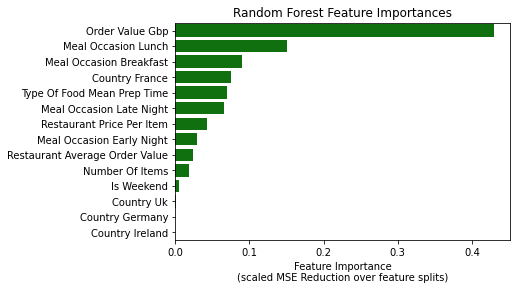

In [16]:
random_forest_model.feature_importance(feature_names=feature_names, plot=True)

We note that features that are **highly correlated** have a **higher variance** in their feature importance, because there is a more even propensity for the decision tree split on either feature.

[From the correlations inferred earlier](#correlations), `restaurant_average_order_value`, `number_of_items`, `restaurant_price_per_item` may have a deflated feature importance, whilst that of `order_value_gbp` may be inflated.


### Further Work

#### Explainability

Because Random Forest is a nonparametric ensemble method, its interpretation of *how* features influence the predictions is limited. <br><br>Further work might explore techniques such as LIME (Locally Interpretable Model-Agnostic Explanations) that can *explain* predictions in terms of the features, by considering local linear perturbations in the feature space. These insights can be used to improve/diagnose the model and drive business decisions for restaurant acquisition (for instance).

<a id='variance'></a>
#### Variance of predictions

For our [**use-cases**](#usecases), it is helpful to have a *prediction interval* that captures the uncertainty of our food prep time predictions.

For tree-based models, we could train with respect to the lower, and upper, quantiles of *all* of the samples in the leaf that a prediction falls in (in contrast with the mean of the samples). A prediction interval are then the values between the lower and upper quantiles of a prediction.<br> *(This is available as the hyperparameter `alpha` in scikit-learn's `GradientBoostingRegressor`.)*

Such *quantile regression* methods that train with respect to quantiles of samples also makes the model **robust to outlier values** in the target variable, which could allow them to be included in the training data.

<a id='evaluation'></a>
# Evaluation

#### Preparation of Test Data

First, we engineer the features for the test set. 

- For features that depend on other datapoints, we only use datapoints in the training set **to avoid data leakage**. 
- There are a *small* number of new restaurants and types of food in the test data, that do not exist in the training data. <br>The values of the corresponding features `restaurant_average_order_value`, `restaurant_price_per_item` and `type_of_food_mean_prep_time` are **mean-imputed** from the training data.

In [17]:
# Engineer orders test set features
test_data['meal_occasion'] = bin_timestamps_to_meal_occasions(test_data['order_acknowledged_at_local'])
test_data['is_weekend'] = bin_timestamps_to_weekend_flag(test_data['order_acknowledged_at_local'])

# Engineer restaurant test set features
test_data = test_data.merge(train_data[['restaurant_id', 'restaurant_price_per_item', 'restaurant_average_order_value']].drop_duplicates(), how='left', on='restaurant_id')
type_of_food_mean_prep_time = target_encode(train_data['type_of_food'], train_data['prep_time_seconds'], leave_one_out=False).drop_duplicates() # Use mean prep time averaged by type_of_food from training set (not leave-one-out)
test_data = test_data.merge(type_of_food_mean_prep_time, how='left', on='type_of_food')

# Engineer one-hot-encoded test set features and, where necessary, mean-impute using training set values
test_data = random_forest_model.one_hot_encode(test_data, categorical_variables)
test_data = random_forest_model.mean_impute_nan_values(test_data, train_data, ['restaurant_price_per_item', 'restaurant_average_order_value', 'type_of_food_mean_prep_time'])

We then generate predictions on the **test set**, to evaluate the model's performance on the unseen test data.

In [18]:
logger.info('TEST SET EVALUATION')
# Generate test set predictions and evaluations
test_predictions = random_forest_model.predict(features=test_data[feature_names])
random_forest_model.evaluate(labels=test_data[label_name], predictions=test_predictions);

TEST SET EVALUATION
{'Mean Absolute Error': '570.02', 'R-Squared': '0.11', '% >10 mins early': '0.12', '% >10 mins late': '0.15'}


<a id='insights'></a>
#### Insights

- On average, the model mispredicts the food preparation time by **570 seconds**, amongst food preparation times under two hours.
- Based on R-Squared, the model is able to explain **11%** of variance in the food preparation time with respect to the features in the test set.
- **12%** of the predictions are >10 minutes earlier than the actual food preparation time, while **15%** are >10 minutes later.

We compare the evaluation on the **test set** with that on the **training set**, as well as a naive **constant** prediction of the mean food prep time in the training set.

In [19]:
logger.info('TRAINING SET EVALUATION')
# Generate training set predictions and evaluations
train_predictions = random_forest_model.predict(features=train_data[feature_names])
random_forest_model.evaluate(labels=train_data[label_name], predictions=train_predictions);

TRAINING SET EVALUATION
{'Mean Absolute Error': '555.77', 'R-Squared': '0.13', '% >10 mins early': '0.12', '% >10 mins late': '0.16'}


In [20]:
logger.info('NAIVE CONSTANT PREDICTION EVALUATION')
# Generate naive training set predictions and evaluations
naive_predictions = [train_data[label_name].mean()] * len(test_data)
random_forest_model.evaluate(labels=test_data[label_name], predictions=naive_predictions);

NAIVE CONSTANT PREDICTION EVALUATION
{'Mean Absolute Error': '614.27', 'R-Squared': '-0.0', '% >10 mins early': '0.13', '% >10 mins late': '0.2'}


The test set performance is only *marginally worse* than the training set performance, indicating that the model has neither overfit nor underfit.

Compared to a naive, constant prediction using the mean food prep time in the training set, the model predicts the food prep time on average **44 seconds closer to the actual food prep time**. This corresponds to over 12,000 rider hours per million orders.

#### Where does the model overestimate and underestimate its predictions?

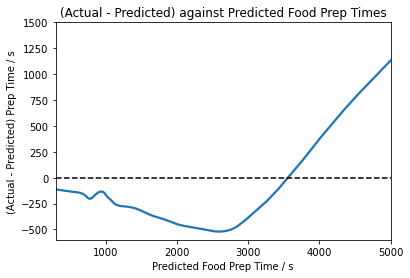

In [21]:
random_forest_model.plot_residuals_against_predictions(labels=test_data[label_name], predictions=test_predictions)

The plot regresses the $(actual - predicted)$ food prep time against $predicted$ food prep time (known as a *residuals vs fits* plot). 

It indicates that up to predicted food prep times of **45 minutes**, the model tends to *overestimate* the food prep time, after which it tends to *significantly underestimate* the food prep time.

With more time, we might evaluate the model conditioned on specific features (e.g. cuisine, time of day) to assess where predictions are better/worse quality. This could suggest increasing the number of training examples for feature combinations that perform poorly.

<a id='usecases'></a>
# Use-cases for Deliveroo

In this section, we offer business use-cases for the models we have developed and suggestions as to how they can be implemented.

### Rider Allocation

When an order is placed, the predicted food preparation time could be used to allocate the best rider to collect the order. <br>

A simple approach could be to allocate the rider whose:<br>
**predicted travel time to the restaurant** is nearest the **predicted food preparation time**


-- or, nearest **some quantile** of the predicted food preparation time (if we have predicted this).<br> The lower this quantile, the relatively earlier the rider arrives to collect the food. This is sensible for orders with more time-sensitive dishes (like a soup) and when the rider network is less busy -- and vice versa. 

We could train the model to directly model the $\alpha$-quantile of the food preparation time, if we want to bias towards earlier or later predictions. The hyperparameter $\alpha$ could be optimised to trade-off the business costs of riders waiting, against the costs of late deliveries. 

<!-- Alternatively, we could measure the difference between travel time and prep time ($t_1$ and $t_2$) as <br>$d(t_1, t_2) = w|t_1 - t_2|$ if $t_1 > t_2$ else $|t_1 - t_2|$ <br>and modify $w$. -->

### Also..

The model could estimate a restaurant's typical food preparation time given the features of a 'typical' order. <br>Together with the [uncertainty](#variance) of this estimation, this could also be used:

- To estimate the total delivery time (food prep time + rider travel time) to present to customers on the app  - particularly for new restaurants with little historical data.
- As a criterion for acquiring restaurants to the platform - the shorter, and the less variance in the predicted food prep time, the better.
- Restaurants with shorter food prep times could be lowered in the search ranking if there are too few available riders in the area, and vice versa.
- If two meals are predicted to be prepared in similar times with low variance, they can be 'pooled' and delivered in one trip.
- As a feature for recommendation and ranking algorithms - food prep time may latently encode 'fast food' vs 'freshly cooked', that could discriminate customer preferences.

<a id='production'></a>
### Productionisation

The main use-case for this model, optimising rider allocation, requires it to serve predictions in real-time. <br>In AWS, a Lambda function could trigger cached prediction features in Redis to be migrated to Sagemaker, that generates the prediction.

Training, on the other hand, can be offline. A high-level overview of its possible deployment is summarised as follows:

- A scheduled SQL query generates the training & prediction data and stores it in a relational database.<br>
- A Continuous Integration pipeline (like CircleCI) runs tests, builds a Docker image (containing source code etc) and an orchestrator downloads the data and runs the pipelines for training & evaluation. Evaluation metrics are logged and the model is serialised in Cloud Storage.

<a id='furtherwork'></a>
# Further Work

In this project, we performed exploratory data analysis, trained and evaluated a model to predict food preparation times, and discussed potential use-cases at Deliveroo. If this model were to be deployed in production, we could consider the following:

### Deployment

It is important that our software is robust and runs on the production infrastructure, so in reality:

- **Testing**<br>
Unit and integration tests would be written to make sure individual parts of the source code behave as intended and that they work together in the production environment. <br><br>

- **Version Control**<br>
Code would be stored in a repository, in which newly pushed changes are peer-reviewed to spot problems early, ensure code quality and share project knowledge.<br><br>



### Features

The [R-Squared scores](#insights) are suggestive that additional features could improve the model. We hypothesise the following features:

- **Restaurant Presence**<br>
Is the restaurant present on Just Eat/Uber Eats? (web-scraped)<br>
If the restaurant offers dine-in, how much footfall? (Google Maps metadata)<br><br>
- **Restaurant Features**<br>
Menu size, Hygiene rating, Food quality (from ratings/reviews)<br>
How new is the restaurant to the platform?<br>
Is the restaurant part of larger chain? (so restaurant metadata can be combined)<br><br>
- **Logistics**<br>
Does the restaurant experience mostly punctual or late riders?<br>
Does the restaurant have a policy to start preparing food once the rider arrives, or beforehand?<br>